In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from data_loader import load_pickle
from ADM import ADM
import seaborn as sns
sns.set()

In [281]:
def simple_spike_generator(freq, duration):
    indices = []
    times = []
    timesteps = int(freq * duration / second)
    indices = np.zeros(timesteps)
    times = np.arange(0, duration / second, 1 / freq)

    return SpikeGeneratorGroup(1, indices, times * second)

In [362]:
def sinusoidal_ADM_spike_generator(signal_freq, duration):
    fs = 32 # Hz
    signal = np.sin(np.arange(0, duration / second, 1 / fs) * signal_freq * 2 * np.pi)
    up_spikes, down_spikes = ADM(
        signal,
        up_threshold=0.005,
        down_threshold=0.005,
        sampling_rate=fs,
        refractory_period=0
    )
    
    spike_generator_up = SpikeGeneratorGroup(1, np.zeros(len(up_spikes)), up_spikes * second)
    spike_generator_down = SpikeGeneratorGroup(1, np.zeros(len(down_spikes)), down_spikes * second)
    
    return spike_generator_up, spike_generator_down

In [505]:
LIF_neuron_model = {
    'model': '''
             dv/dt = (-v + R * I_syn_exc) / tau : volt
             tau : second
             R : ohm
             refP: second
             
             dI_syn_exc/dt = -I_syn_exc / tau_syn : amp
             tau_syn : second
             ''',
    'threshold': 'v > 1 * volt',
    'reset': 'v = 0 * volt',
    'method': 'euler',
    'refractory': 'refP'
}

exc_synapse_model = {
    'model': 'weight : 1',
    'on_pre': 'I_syn_exc_post += weight / tau_syn_post * second * amp',
    'method': 'euler'
}

In [544]:
# initialize synapse parameters
num_neurons = 20

tau_syn_values = np.linspace(0.05, 0.5, num_neurons)

In [545]:
spike_counts = []
num_frequencies = 20
frequencies = np.linspace(0.5, 4, num_frequencies)
for signal_freq in frequencies:

    device.reinit()
    device.activate()
    defaultclock.dt = 500 * us
    duration = 4 * second

    network = Network()

    # create neurons, synapses
    spike_generator_up, _ = sinusoidal_ADM_spike_generator(signal_freq, duration)
    N = NeuronGroup(num_neurons, **LIF_neuron_model)
    S_up = Synapses(spike_generator_up, N, **exc_synapse_model)
    S_up.connect(True)

    # set parameters
    N.tau = 0.1 * second
    N.R = 1 * ohm
    N.tau_syn = tau_syn_values * second
    N.I_syn_exc = 0.001 * amp
    N.refP = 0 * ms
    S_up.weight = 0.042

    # create monitors
    mon_synapse_state = StateMonitor(S_up, 'I_syn_exc', record=True)
    mon_neuron_state  = StateMonitor(N,  'v', record=True)
    mon_neuron_input  = SpikeMonitor(spike_generator_up, name='mon_neuron_input')
    mon_neuron_output = SpikeMonitor(N, name='mon_neuron_output')


    # add elements to network
    network.add([spike_generator_up, N, S_up,
                 mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

    # simulation
    network.run(duration)
    
    # save spike counts
    spike_counts.append(mon_neuron_output.count)


In [546]:
def plot_neuron_responses(values, frequencies, name_of_values):
    values = np.array(values)
    plt.figure(figsize=(16,10),dpi=150)
    norm = mpl.colors.Normalize(vmin=0, vmax=values.shape[1])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('viridis_r'))
    for i in range(values.shape[1]):
        plt.plot(frequencies, values[:, i], label=round(tau_syn_values[i], 2), color=cmap.to_rgba(i))
        plt.fill_between(frequencies, values[:, i], color=cmap.to_rgba(i), alpha=1)
    plt.legend(title='tau_syn values')
    plt.xticks(fontsize=12)
    plt.xlabel('Sine input frequency [Hz]', fontsize=14)
    plt.yticks(fontsize=12)
    plt.ylabel('Output frequency [Hz]', fontsize=14)
    plt.title(name_of_values + ' of DPI neurons with different excitatory synaptic time constants', fontsize=15)

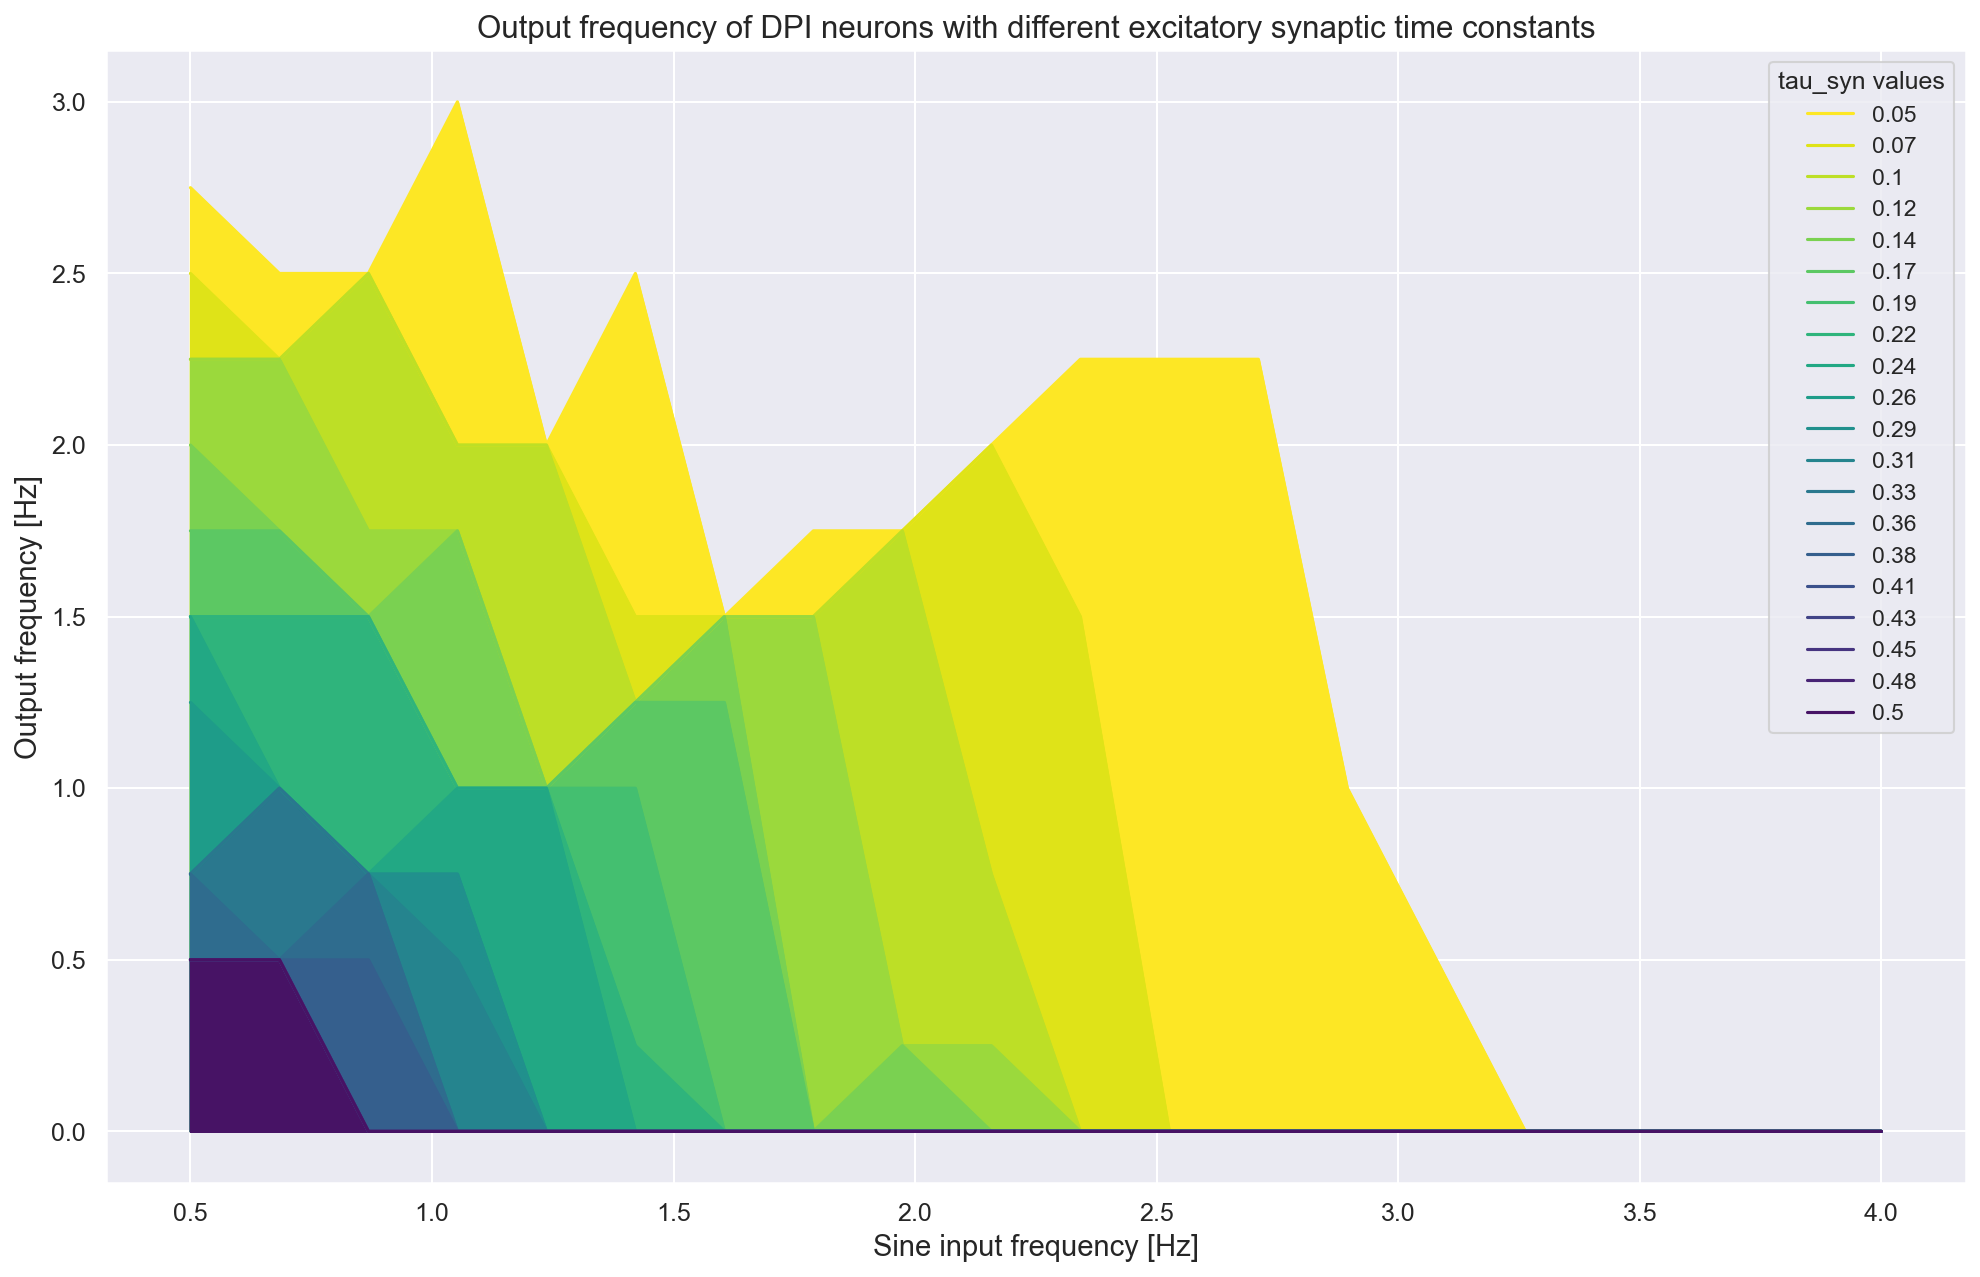

In [547]:
plot_neuron_responses(spike_counts / duration / second, frequencies, 'Output frequency')

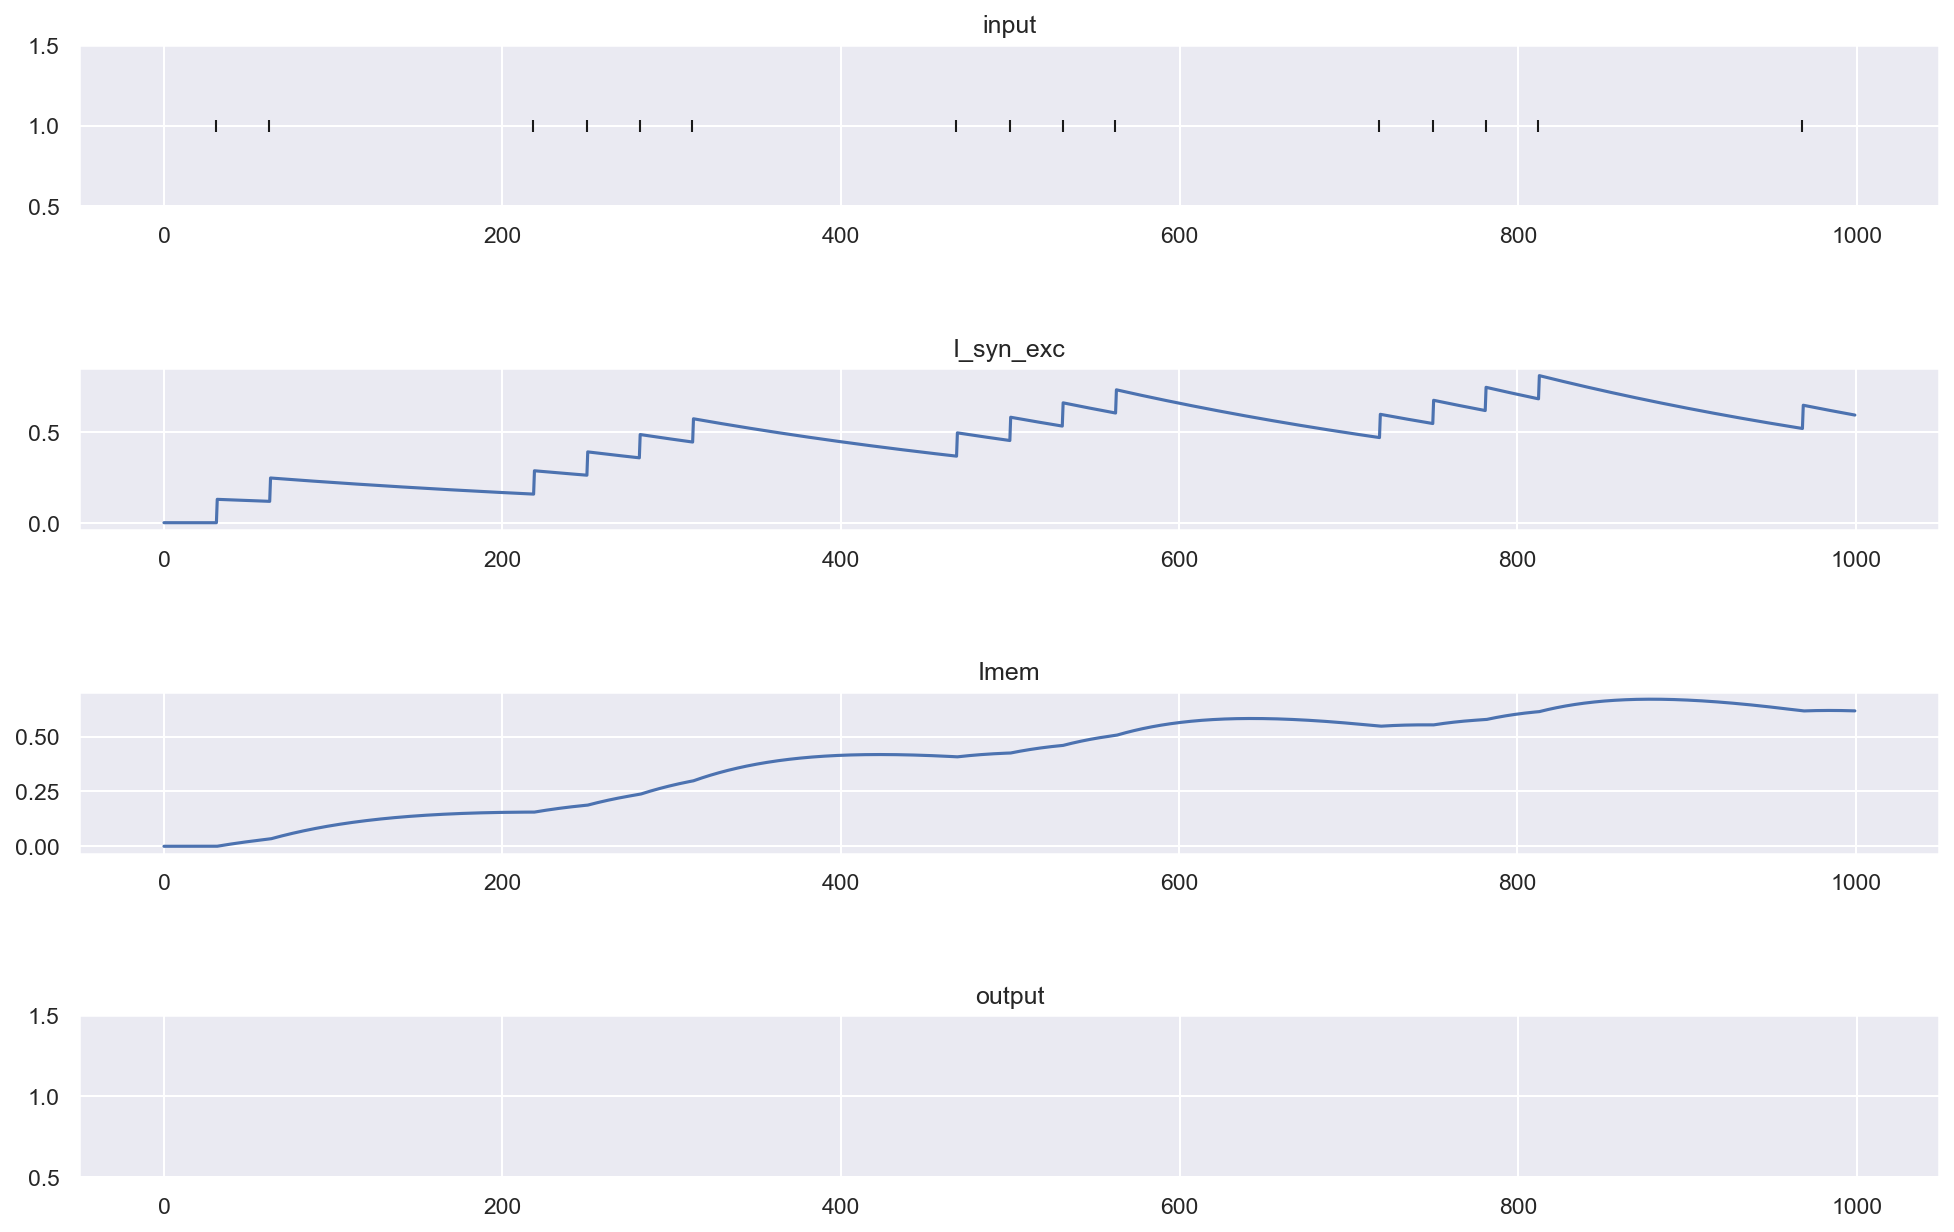

In [522]:
plt.figure(figsize=(16,10),dpi=150)
plt.subplots_adjust(hspace=1)

output_idx = 5

plt.subplot(411)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('input')

plt.subplot(412)
plt.plot(mon_synapse_state.t / ms, mon_synapse_state.I_syn_exc[output_idx])
plt.title('I_syn_exc')

plt.subplot(413)
plt.plot(mon_neuron_state.t / ms, mon_neuron_state.v[output_idx])
plt.title('Imem')


plt.subplot(414)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
relevant_timestamps = mon_neuron_output.t[mon_neuron_output.i == output_idx]
spike_placeholder[np.array(relevant_timestamps/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('output')



plt.show()